In [71]:
"""Sandbox module."""
import matplotlib.pyplot as plt
import numpy as np

from fda_funcs import (
    compute_moments,
    compute_principal_components,
    compute_fpc_scores,
    mode_of_variation
)

from misc import (
    cdf_from_density,
    density_from_qd,
    l2_norm,
    norm_pdf,
    norm_cdf,
    quantile_from_cdf,
    riemann_sum_arrays,
    trunc_norm_pdf,
)

from data_generation import(
    gen_grids_and_parameters,
    gen_discretized_distributions
)

import warnings
%matplotlib inline

## Fréchet mean estimation

In [72]:
def gen_grids_and_parameters(n, gridnum, truncation_point, delta):
    """Generate parameters for the density samples and define appropriate grids."""

    grid_densities = np.linspace(
        start=-truncation_point,
        stop=truncation_point,
        num=gridnum,
    )
    grid_quantiles = np.linspace(start=delta, stop=1-delta, num=gridnum)

    # Draw different sigmas
    log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
    mus = np.zeros(n)
    sigmas = np.exp(log_sigmas)

    return (
        grid_densities,
        grid_quantiles,
        mus,
        sigmas
    )

In [188]:
def gen_discretized_distributions(grid_pdfs, grid_qfs, mus, sigmas, truncation_point):
    """Generate discretized pdfs, cdfs, qfs, and qdfs."""
    # Truncated pdfs
    pdfs_discretized = trunc_norm_pdf(
        grid_pdfs[:, np.newaxis],
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    )

    # Truncated cdfs
    cdfs_discretized = cdf_from_density(
        grid_pdfs,
        pdfs_discretized,
        axis=1,
    )

    # Truncated qfs
    qfs_discretized = quantile_from_cdf(
        grid_pdfs[:, np.newaxis].transpose(),
        cdfs_discretized,
        grid_qfs,
    )

    # Truncated qdfs
    qdfs_discretized = np.reciprocal(
        trunc_norm_pdf(
            qfs_discretized.transpose(),
            mus,
            sigmas,
            -truncation_point,
            truncation_point,
        ),
    )

    # Normalize quantile densities
    range_pdfs = grid_pdfs[-1] - grid_pdfs[0]
    integrals_qdfs = riemann_sum_arrays(grid_qfs, qdfs_discretized, axis = 1)[:, np.newaxis]
    qdfs_discretized *= range_pdfs / integrals_qdfs

    return pdfs_discretized, cdfs_discretized, qfs_discretized, qdfs_discretized

In [189]:
# Set up data
n = 200
gridnum = 1000
truncation_point = 3

grid_pdfs1, grid_qfs1, mus1, sigmas1 = gen_grids_and_parameters(
    n, gridnum, truncation_point, 0
)
grid_pdfs2, grid_qfs2, mus2, sigmas2 = gen_grids_and_parameters(
    n, gridnum, truncation_point, 1e-3
)

In [190]:
def trunc_norm_pdf(x, mu, sigma, a, b):
    """Define truncated normal density function.

    To test: columns of x must align with mu and sigma.

    """
    x = np.array(x)  # to vectorize the input
    mu = np.array(mu)
    sigma = np.array(sigma)
    x_std = (x - mu) / sigma
    a_std = (a - mu) / sigma
    b_std = (b - mu) / sigma
    numerator = norm_pdf(x_std, 0, 1)
    denominator = norm_cdf(b_std, 0, 1) - norm_cdf(a_std, 0, 1)

    result = numerator / denominator / sigma
    
    # Create a boolean mask for values outside the interval [a, b]
    mask = (x_std < a_std) | (x_std > b_std)

    # Set the PDF to zero for values of x outside the interval [a, b]
    result[mask] = 0
    result = result.transpose()

    # Check whether each density integrates to 1
    eps = 1e-5
    integrals = riemann_sum_arrays(np.linspace(a, b, len(x)), result, axis = 1)
    deviations_from_1 = abs(integrals - 1)
    if np.any(deviations_from_1 > eps):
        warnings.warn(
            "Not all provided densities integrate to 1!"
            f"\n Max case of deviation is: {deviations_from_1.max()} "
            f"\n In position: {deviations_from_1.argmax()} "
            "\n Performing normalization...",
        )
        # result /= integrals[:, np.newaxis]
    return result

In [191]:
# Generate distributions
pdfs_discretized1, cdfs_discretized1, qfs_discretized1, qdfs_discretized1 = (
    gen_discretized_distributions(grid_pdfs1, grid_qfs1, mus1, sigmas1, truncation_point)
)

C:\Users\oecal\AppData\Local\Temp\ipykernel_22184\1539719664.py:30: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.006087386759915159 
 In position: 40 
 Performing normalization...
  warnings.warn(


UnboundLocalError: cannot access local variable 'qdfs_discretized' where it is not associated with a value

In [173]:
pdfs_discretized2, cdfs_discretized2, qfs_discretized2, qdfs_discretized2 = (
    gen_discretized_distributions(grid_pdfs2, grid_qfs2, mus2, sigmas2, truncation_point)
)

C:\Users\oecal\AppData\Local\Temp\ipykernel_22184\1539719664.py:30: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.006087386759915159 
 In position: 40 
 Performing normalization...
  warnings.warn(
C:\Users\oecal\AppData\Local\Temp\ipykernel_22184\1539719664.py:30: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 6.279919032563649 
 In position: 151 
 Performing normalization...
  warnings.warn(


In [174]:
lim1 = 999
lim2 = 999
integral1 = riemann_sum_arrays(grid_qfs1[:lim1], qdfs_discretized1[0][:lim1], axis=0)
integral2 = riemann_sum_arrays(grid_qfs1[:lim2], tempi[0][:lim2], axis=0)
integral1, integral2, grid_qfs1[lim1], grid_qfs2[lim2]

(2.871988109252022, 0.9600054746951162, 1.0, 0.999)

In [175]:
mean_function1, centered_densities, cov_matrix = compute_moments(pdfs_discretized1)
mean_function2, centered_densities, cov_matrix = compute_moments(pdfs_discretized2)

0.9939126132400851

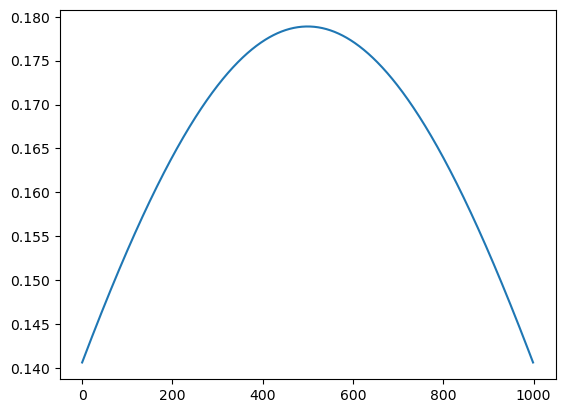

In [183]:
whi = 40
plt.plot(pdfs_discretized1[whi])
riemann_sum_arrays(grid_pdfs1, pdfs_discretized1[whi], axis = 0)

In [176]:
def dens2qd(dens, dsup=None, qdsup=None):
    """Compute quantile densities directly from densities."""
    # Validate input
    if not np.allclose([np.min(qdsup), np.max(qdsup)], [0, 1], atol=1e-4):
        print([np.min(qdsup), np.max(qdsup)])
        raise ValueError("Please check the support of the QF domain's boundaries.")
    
    integral_dens = riemann_sum_arrays(dsup, array=dens, axis=0, cumsum=True)
    eps = 1e-3
    deviations_from_1 = abs(integral_dens[..., -1] - 1)
    if np.any(deviations_from_1 > eps):
        warnings.warn(
            "Not all provided densities integrate to 1!"
            f"\n Max case of deviation is: {deviations_from_1.max()} "
            f"\n In position: {deviations_from_1.argmax()} "
            "\n Performing normalization...",
        )
    
    # Calculate new support grid
    qdtemp = integral_dens
    
    # Calculate density
    qdens = 1 / dens
    
    # # Normalize the density
    # qdens = qdens_temp
    qdens /= riemann_sum_arrays(qdsup, qdens, axis=1, cumsum=False)[:, np.newaxis]
    
    return qdens, qdtemp

In [154]:
tempi = dens2qd(pdfs_discretized1, grid_pdfs1, grid_qfs1)[0]

C:\Users\oecal\AppData\Local\Temp\ipykernel_22184\1769881519.py:12: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.9999999999972077 
 In position: 0 
 Performing normalization...
  warnings.warn(


In [155]:
(tempi[0]- qdfs_discretized1[0]).max()

36.684047554702474

In [156]:
def qd2dens(qds_discretized, qdsup=None, dsup=None):
    # Validate input

    if not np.allclose([np.min(qdsup), np.max(qdsup)], [0, 1], atol=1e-1):
        print([np.min(qdsup), np.max(qdsup)])
        raise ValueError("Please check the support of the qds_discretized domain's boundaries.")
    
    integral_qd = riemann_sum_arrays(qdsup, array=qds_discretized, axis=0, cumsum=True)
    if not np.isclose(integral_qd[-1], np.ptp(dsup), atol=1e-5):
        print(integral_qd, np.ptp(dsup))
        raise ValueError("Quantile Density should integrate to the range of dsup.")
    
    # Calculate new support grid
    dtemp = dsup[0] + integral_qd
    
    # Calculate density
    dens_temp = 1 / qds_discretized
    dtemp, idx_unique = np.unique(dtemp, return_index=True)
    dens_temp = dens_temp[idx_unique]
    dens = np.interp(dsup, dtemp, dens_temp)
    # dens_interp = CubicSpline(dtemp, dens_temp, bc_type='natural')
    # dens_interp = interp1d(dtemp, dens_temp, kind='linear', fill_value="extrapolate")
    # dens = dens_interp(dsup)
    
    # Normalize the density
    dens /= riemann_sum_arrays(dsup, dens, axis=0, cumsum=False)
    
    return dens, dtemp

In [157]:
def density_from_qd(qds_discretized, dsup, qdsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    if qdsup is None:
        qdsup = np.linspace(0, 1, len(qds_discretized))
    quantile_oplus = dsup[0]  + riemann_sum_arrays(
        support_grid=qdsup, array=qds_discretized, axis=0, cumsum=True
    )

    dens_temp = 1 / qds_discretized
    # ind = np.unique(quantile_oplus, return_index=True)[1]
    # quantile_oplus = np.atleast_1d(quantile_oplus)[ind]
    # dens_temp = dens_temp[~ind]
    dens = np.interp(dsup, quantile_oplus, dens_temp)
    dens /= riemann_sum_arrays(dsup, dens, axis=0, cumsum=False)

    return dens, quantile_oplus

In [158]:
def wasserstein_frechet_mean(qds_discretized, dsup, qdsup=None):
    """Compute Wasserstein-Fréchet mean from sample."""
    if qdsup is None:
        qdsup = np.linspace(0, 1, qds_discretized.shape[1])
    mean_qdf = np.mean(qds_discretized, axis=0)
    integral = riemann_sum_arrays(qdsup, array=mean_qdf, axis=0, cumsum=False)
    mean_qdf *= (dsup[-1] - dsup[0]) / integral
    # return density_from_qd(mean_qdf, dsup, qdsup)
    return qd2dens(mean_qdf, qdsup=qdsup, dsup=dsup)

In [159]:
f_oplus1, quantile_oplus1 = wasserstein_frechet_mean(
    tempi,
    grid_pdfs1,
    grid_qfs1
)
F_oplus1 = cdf_from_density(
    grid_pdfs1,
    f_oplus1,
    axis=0,
)
f_oplus2, quantile_oplus2 = wasserstein_frechet_mean(
    qdfs_discretized2,
    grid_pdfs2,
    grid_qfs2
)
F_oplus2 = cdf_from_density(
    grid_pdfs2,
    f_oplus2,
    axis=0,
)

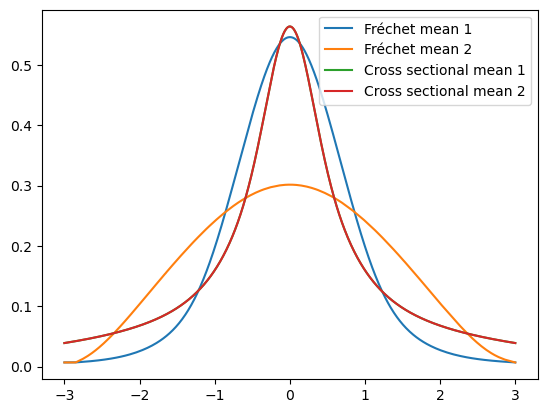

In [160]:
fig, ax = plt.subplots()
ax.plot(grid_pdfs1, f_oplus1, label="Fréchet mean 1")
ax.plot(grid_pdfs2, f_oplus2, label="Fréchet mean 2")
ax.plot(grid_pdfs1, mean_function1, label="Cross sectional mean 1")
ax.plot(grid_pdfs2, mean_function2, label="Cross sectional mean 2")
plt.legend()
plt.show()

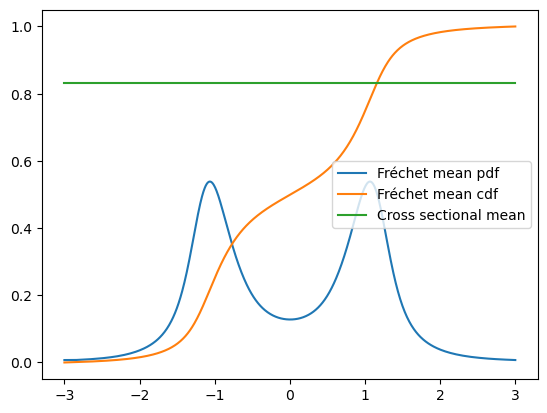

In [119]:
fig, ax = plt.subplots()
ax.plot(grid_pdfs1, f_oplus1, label="Fréchet mean pdf")
ax.plot(grid_pdfs1, F_oplus1, label="Fréchet mean cdf")
ax.plot(grid_pdfs1, mean_function1, label="Cross sectional mean")
plt.legend()
plt.show()